In [28]:
import numpy as np
import tensorflow as tf
from keras import backend as K


def iou(pivot_box, boxes):
    """
    Arguments:
    pivot_box -- one box, tensor of shape (4) (y1, x1, y2, x2)
    boxes -- comparing boxes, tensor of shape (None, 4) (y1, x1, y2, x2)
    
    Returns:
    ious -- tensor of shape (None, 1), iou values 
    """        
    py1 = tf.minimum(pivot_box[0], pivot_box[2])
    py2 = tf.maximum(pivot_box[0], pivot_box[2])
    px1 = tf.minimum(pivot_box[1], pivot_box[3])
    px2 = tf.maximum(pivot_box[1], pivot_box[3])
    
    by1 = tf.minimum(boxes[:, 0], boxes[:, 2])
    by2 = tf.maximum(boxes[:, 0], boxes[:, 2])
    bx1 = tf.minimum(boxes[:, 1], boxes[:, 3])
    bx2 = tf.maximum(boxes[:, 1], boxes[:, 3])
    
    ix = tf.subtract(tf.minimum(px2, bx2), tf.maximum(px1, bx1))
    iy = tf.subtract(tf.minimum(py2, by2), tf.maximum(py1, by1))
    
    intersect = tf.maximum(tf.multiply(ix, iy), 0.)
    b1 = tf.multiply(tf.subtract(px2, px1), tf.subtract(py2, py1))
    b2 = tf.multiply(tf.subtract(bx2, bx1), tf.subtract(by2, by1))
    union = tf.subtract(tf.add(b1, b2), intersect)
    
    return tf.divide(intersect, union)
    

def scale_boxes(boxes, box_dimension, image_dimension):
    """
    Scale (y1, x1, y2, x2) cooridnates accordant to the image_shape
    
    Arguments:
    boxes -- tensor of shape (..., 4)
    box_dimension -- tuple (height, width), shape of boxes coordinate
    image_dimension -- tuple (height, width), shape of target dimension
    
    Returns:
    boxes -- tensor of shape (..., 4)
    """
    ratio_h = image_dimension[0] / box_dimension[0] 
    ratio_w = image_dimension[1] / box_dimension[1]
    return tf.stack([
        tf.multiply(boxes[..., 0], ratio_h), 
        tf.multiply(boxes[..., 1], ratio_w), 
        tf.multiply(boxes[..., 2], ratio_h), 
        tf.multiply(boxes[..., 3], ratio_w)], axis=-1)
    
    
def non_max_suppression(scores, boxes, classes, max_boxes=10, iou_threshold=0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None,), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. 
    """
    
    z_score = tf.zeros_like(scores)
    z_box = tf.zeros_like(boxes)

    nms_indices = tf.Variable([], dtype=tf.int64)
    K.get_session().run(tf.variables_initializer([nms_indices])) # initialize variable nms_indices
    
    def cond(tscores, tboxes, indices):
        return tf.logical_not(tf.reduce_all(tf.equal(tscores, z_score)))
    
    def body(tscores, tboxes, indices):
        # find the box with maximum score
        maxidx = tf.argmax(tscores)
        indices = tf.concat([indices, [maxidx]], axis=-1)
        
        # mark the rests that have less scores than iou_threshold
        iou_mat = iou(tboxes[maxidx], tboxes)
        mask = tf.less_equal(iou_mat, iou_threshold)

        tscores = tf.where(mask, tscores, z_score)
        tboxes = tf.where(mask, tboxes, z_box)
        
        return [tscores, tboxes, indices]
 
    final = tf.while_loop(cond, body, loop_vars=[scores, boxes, nms_indices],\
                          shape_invariants=[scores.get_shape(), boxes.get_shape(), tf.TensorShape([None, ])], \
                          maximum_iterations=max_boxes)
                
    scores = K.gather(scores, final[2])
    boxes = K.gather(boxes, final[2])
    classes = K.gather(classes, final[2])
    
    return scores, boxes, classes


def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes_tensor, iou_threshold=iou_threshold)
    
    # Use K.gather() to select only nms_indices from scores, boxes and classes
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    
    return scores, boxes, classes


def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.6):
    """
    Arguments:
    box_confidence -- tensor of shape (..., 1)
    boxes -- tensor of shape (..., 4)
    box_class_probs -- tensor of shape (..., C), C - number of classes
    threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box

    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes

    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.    
    """

    box_scores = tf.multiply(box_confidence, box_class_probs)    # confidence broadcasted
    box_max_classes = tf.argmax(box_scores, axis=-1)
    box_max_scores = K.max(box_scores, axis=-1)
    
    mask = box_max_scores >= threshold
    
    scores = tf.boolean_mask(box_max_scores, mask)
    boxes = tf.boolean_mask(boxes, mask)
    classes = tf.boolean_mask(box_max_classes, mask)
    
    return scores, boxes, classes
    
    
def yolo_boxes_to_corners(box_xy, box_wh):
    """
    Converts the output of YOLO to (y1, x1, y2, x2)
    Arguments
    box_xy -- tensor of shape (..., 2)
    box_wh -- tensor of shape (..., 2)
    
    Returns:
    boxes -- tensor of shape (..., 4)
    """
    box_half = box_wh/2.
    
    box_x = box_xy[..., 0]
    box_y = box_xy[..., 1]
    box_hw = box_half[..., 0]
    box_hh = box_half[..., 1]
    
    boxes = tf.stack([
        tf.subtract(box_y, box_hh), 
        tf.subtract(box_x, box_hw), 
        tf.add(box_y, box_hh), 
        tf.add(box_x, box_hw)], axis=-1)
    
    return boxes
    
    
def yolo_eval(yolo_outputs, image_shape=[720, 1280], max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tuple (height, width) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    
    # filter via score_threshold
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold=score_threshold)
    
    # scale the model output to the original image shape
    boxes = scale_boxes(boxes, [1, 1], image_shape)
    
    scores, boxes, classes = non_max_suppression(
        scores, 
        boxes, 
        classes, 
        max_boxes = max_boxes, 
        iou_threshold=iou_threshold)
    
    return scores, boxes, classes
    

C:\ProgramData\Anaconda3\lib\site-packages\keras\models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


image data shape:  (1, 416, 416, 3)
Found 8 boxes for DSCN1749.jpg
person 0.34 (930, 128) (1083, 957)
car 0.37 (1496, 372) (1593, 674)
handbag 0.53 (756, 659) (890, 879)
person 0.71 (836, 159) (1054, 1007)
person 0.75 (698, 190) (900, 1036)
chair 0.76 (59, 471) (467, 1073)
person 0.84 (1078, 160) (1333, 1006)
person 0.85 (537, 195) (767, 1111)
0.84526


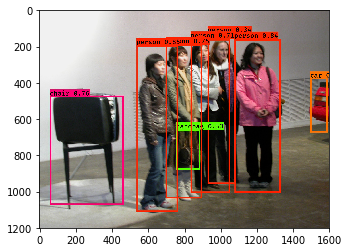

In [31]:
from keras.models import load_model, Model
from yad2k.models.keras_yolo import yolo_head, yolo_body
import imghdr
import colorsys
import random
from PIL import Image, ImageDraw, ImageFont


def load_classes(filepath):
    with open(filepath) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]

    return class_names
    

def load_anchors(filepath):
    with open(filepath) as f:
        anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        anchors = np.array(anchors).reshape(-1, 2)
    
    return anchors
    

def preprocess_image(image_file, model_image_size):
    is_fixed_size = model_image_size != (None, None)

    image_type = imghdr.what(image_file)
    if not image_type:
        return None, None

    image = Image.open(image_file)
    if is_fixed_size:  # TODO: When resizing we can use minibatch input.
        resized_image = image.resize(
            tuple(reversed(model_image_size)), Image.BICUBIC)
        image_data = np.array(resized_image, dtype='float32')
    else:
        # Due to skip connection + max pooling in YOLO_v2, inputs must have
        # width and height as multiples of 32.
        new_image_size = (image.width - (image.width % 32),
                          image.height - (image.height % 32))
        resized_image = image.resize(new_image_size, Image.BICUBIC)
        image_data = np.array(resized_image, dtype='float32')
        print(image_data.shape)

    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    
    return image, image_data
    

def generate_colors(class_names):
    # Generate colors for drawing bounding boxes.
    hsv_tuples = [(x / len(class_names), 1., 1.)
                  for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(
        map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
            colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    
    return colors


def draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors):
    font = ImageFont.truetype(
        font='font/FiraMono-Medium.otf',
        size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]

        label = '{} {:.2f}'.format(predicted_class, score)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i],
                outline=colors[c])
        draw.rectangle(
            [tuple(text_origin), tuple(text_origin + label_size)],
            fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw
        

from matplotlib.pyplot import imshow
import os
import scipy.misc

%matplotlib inline

# Keras session
with tf.Session() as sess:

    # load model
    class_names = load_classes("model_data/coco_classes.txt")
    anchors = load_anchors("model_data/yolov2_anchors.txt")

    yolo_model = load_model("model_data/yolov2.h5")    
    yolo_output = yolo_head(yolo_model.output, anchors, len(class_names))

    # Check if model is fully convolutional, assuming channel last order.
    model_image_size = yolo_model.layers[0].input_shape[1:3]

    input_image_shape = K.placeholder(shape=(2,))
    max_boxes = 10
    score_threshold = .3
    iou_threshold = .5

    scores, boxes, classes = yolo_eval(
        yolo_output, 
        input_image_shape, 
        max_boxes = max_boxes, 
        score_threshold = score_threshold, 
        iou_threshold = iou_threshold)

    # Preprocess your image
    image_file = "DSCN1749.jpg"
    image, image_data = preprocess_image(os.path.join("images", image_file), model_image_size)

    print("image data shape: ", image_data.shape)

    # predict
    out_scores, out_boxes, out_classes, out_yolo = sess.run(
        [scores, boxes, classes, yolo_output], 
        feed_dict={
            yolo_model.input: image_data, 
            input_image_shape: [image.size[1], image.size[0]], 
            K.learning_phase(): 0
        }
    )

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=90)
    # Display the results in the notebook
    output_image = scipy.misc.imread(os.path.join("out", image_file))
    imshow(output_image)    

    box_xy, box_wh, box_confidence, box_class_probs = out_yolo
    print(np.amax(box_confidence * box_class_probs))
    

In [100]:
with tf.Session() as test_b:
    yolo_outputs = (tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
    scores, boxes, classes = yolo_eval(yolo_outputs)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

scores[2] = 138.791
boxes[2] = [ -278.52166748  -470.00527954  2297.47509766  3876.98925781]
classes[2] = 54
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


In [137]:
a = np.array([[1, 2]])
print(a[..., 1:2])

[[2]]
